In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))
sys.path.append(op.abspath('../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../')

# Selection and analysis of peaked background


## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from numba import jit

from lib import plot as lp, data, clustering

from project import defs, files, col
from project.defs import dict_color_clu_labels


## Load dataframe

In [3]:
list_voi = [
    'pos_max', #'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean',
]

columns = [
    'max_m_mean',
    'min_std_pos_neg',
    'min_std_pos_neg_redpn',
    'max_m_mean_red',
    'mean_rounded',
    "max_m_mean_rounded",
    'max_m_min',    
    "std_d_max_m_min",
    "std_without_neg_peaks_d_max_m_min",
    "std_without_pos_peaks_d_max_m_min",
    "relative_mean",
    "std_period_d_mean_period"
]

other_columns = [
    "nb_peaks_sup_80_wrt_min",
    "best_chi2"
]

other_columns += [
    "nb_pos_peaks",
    "nb_neg_peaks"
]

other_columns += [
    "std_without_pos_peaks",
    "std_without_neg_peaks"
]

other_columns += [
    "mean_period_max",
    "mean_period_min",
    "mean_period",
    "std_period_max",
    "std_period_min",
]

other_columns += [
    "mean2_diff_max",
    "mean2_diff_min",
    "mean2_diff"
]


layer = 0

print("Layer", layer, "="*10)
config_name = f"BDT_SNP_layer_{layer}"
file_path = files.get_path_processed_root(config_name)
dataframe, column_labels = files.load_and_process_dataframe(
    file_path, list_voi, columns, other_columns,
    branches=defs.list_samples_columns+["eta", "phi", "region", "detector", "channelId"],
    verbose=True
)

Layer 0 ==========


FileNotFoundError: file not found

    '/mnt/e/900GeV/processed/simulation/BDT_SNP_layer_0.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [56]:
dataframe.query("max - min > 3", inplace=True)

## Selection of peaked background

Peaked background is selected knowing that:
- It is not a signal event: $\chi^2 > 0.05$, and we could be even more stringent
- For a small number of peaks, the mean is not centered: it is towards lower or higher values. Otherly said, $\frac{\langle e \rangle - e_{\text{min}}}{e_{\text{max}} - \text{min}} - \frac{1}{2}$ (`relative_mean`) is *far from 0* and *closer to 0.5*
- If the peaks are removed, the standard deviation is limited (w.r.t. the amplitude $e_{\text{max}} - e_{\text{min}}$) : `std_without_neg_peaks_d_max_m_min` or `std_without_pos_peaks_d_max_m_min` is small
- The number of up or down peaks `nb_pos_peaks` or `nb_neg_peaks` must be limited (let's say, $< 10$)

### Selection of up peaks
Here, we focus on positive peaks.

Thus issue with applying a stringent cut on `relative_mean` is that it is correlated with the number of peaks: the more peaks they are, they less `relative_mean` will be far from $0$.

The strategy chosen if thus to impose a loose cut on `displaced_mean` (in order to have only up peaks), and a more stringent cut on `std_without_pos_peaks_d_max_m_min`

## Cut on `best_chi2`

We need to remove signal events. One solution could be to only work in the limited $_{\text{max}} > 10$ subspace. Another solution would be to cut on `best_chi2`. Note that this cut would tend to remove more one-peak events that two-peak events: the cut needs not to be too stringent.

# of events: 621214


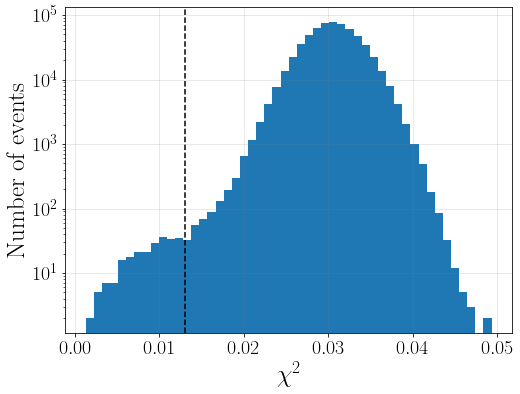

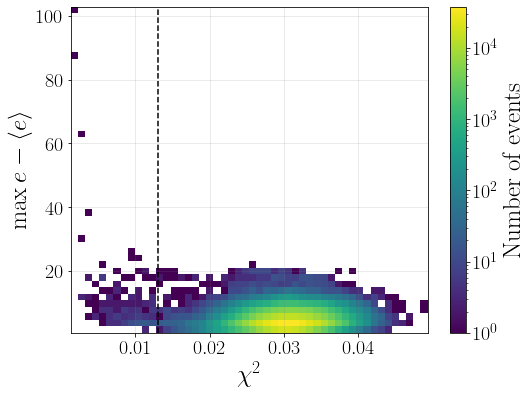

In [57]:
chi2_low = 0.013

fig, ax = lp.plot_hist(
    dataframe["best_chi2"], column_labels["best_chi2"],
    logscale=True
)

fig2, ax2 = lp.plot_hist2d(
    dataframe["best_chi2"],    
    dataframe["max_m_mean"],
    column_labels["best_chi2"],
    column_labels["max_m_mean"],
    logscale=True
)
ax.axvline(
    x=chi2_low, color='k', linestyle='--'
)
ax2.axvline(
    x=chi2_low, color='k', linestyle='--'
)




high_chi2_df = dataframe.query(f"best_chi2 > {chi2_low}")
print("# of events:", len(high_chi2_df))

#### Cut on `displaced_mean`

# of events: 158167


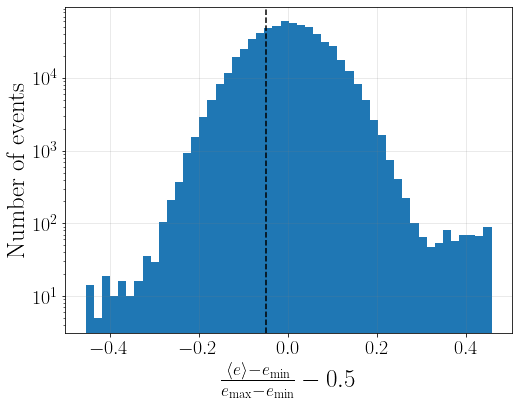

In [58]:
fig, ax = lp.plot_hist(
    high_chi2_df["relative_mean"], column_labels["relative_mean"],
    logscale=True
)

relative_mean_high = -0.05

ax.axvline(
    x=relative_mean_high, color='k', linestyle='--'
)

low_relative_mean_df = high_chi2_df.query(f"relative_mean < {relative_mean_high}")
print("# of events:", len(low_relative_mean_df))

### Cut on `std_without_pos_peaks_d_max_m_min`

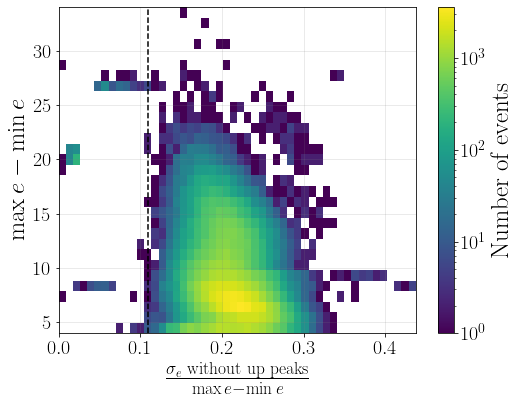

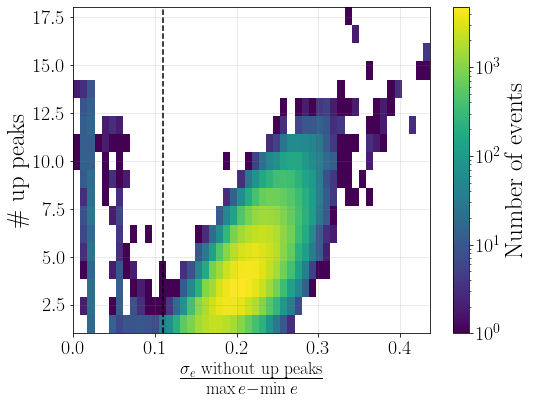

In [59]:
std_without_pos_peaks_d_max_m_min_high = 0.11

fig, ax = lp.plot_hist2d(
    low_relative_mean_df["std_without_pos_peaks_d_max_m_min"],
    low_relative_mean_df["max_m_min"],    
    column_labels["std_without_pos_peaks_d_max_m_min"],
    column_labels["max_m_min"],
    logscale=True,
    bins=[50, "discretised"]
)
fig2, ax2 = lp.plot_hist2d(
    low_relative_mean_df["std_without_pos_peaks_d_max_m_min"],
    low_relative_mean_df["nb_pos_peaks"],    
    column_labels["std_without_pos_peaks_d_max_m_min"],
    column_labels["nb_pos_peaks"],
    logscale=True,
    # min_max=(None, (0, 25)),
    bins=[50, "discretised"]
)
ax.axvline(
    x=std_without_pos_peaks_d_max_m_min_high, 
    color='k', linestyle='--'
)
ax2.axvline(
    x=std_without_pos_peaks_d_max_m_min_high, 
    color='k', linestyle='--'
)


#### Fast check of what is around 0.1

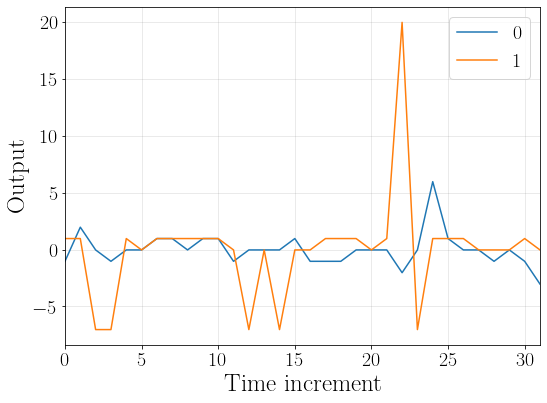

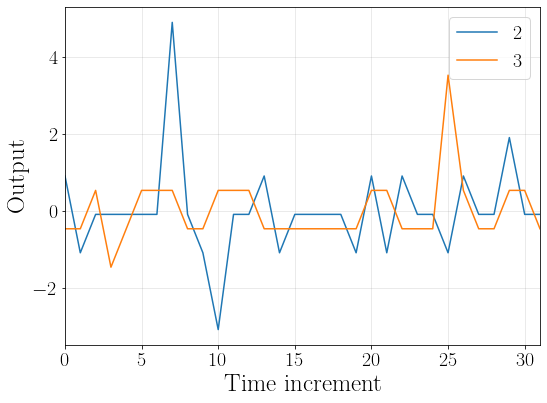

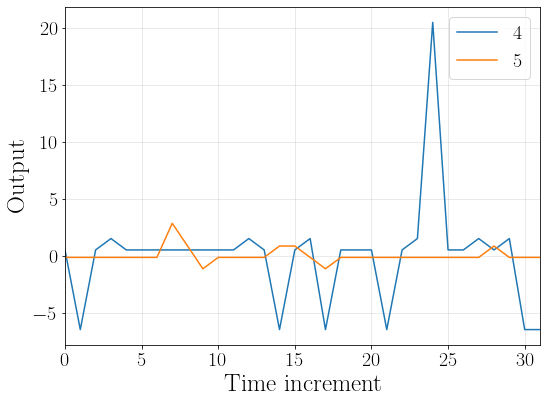

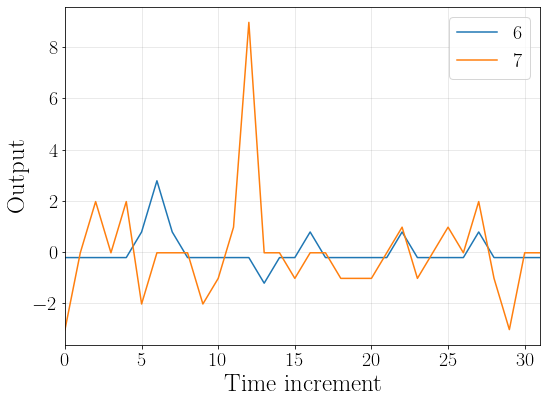

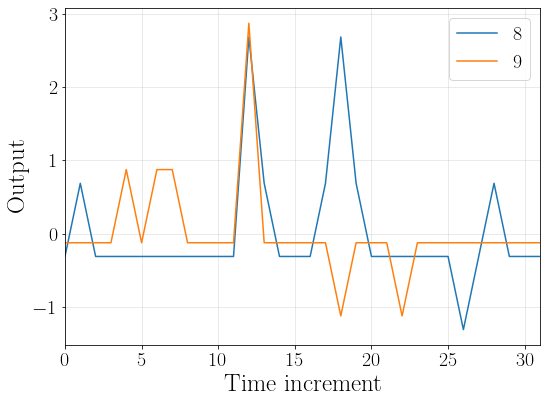

In [60]:
lp.plot_samples_lots(
    low_relative_mean_df.query(
        "std_without_pos_peaks_d_max_m_min > 0.1 and std_without_pos_peaks_d_max_m_min < 0.11"
    ).sample(10),
    minus_mean=True
)

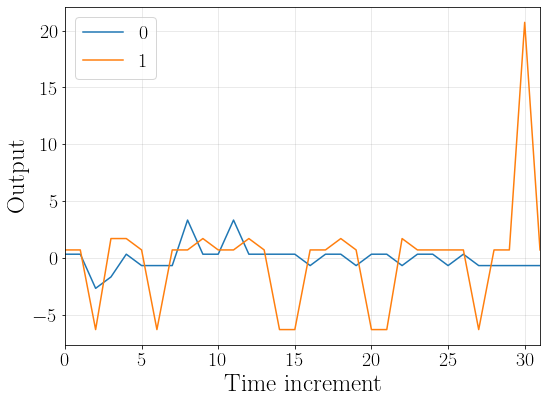

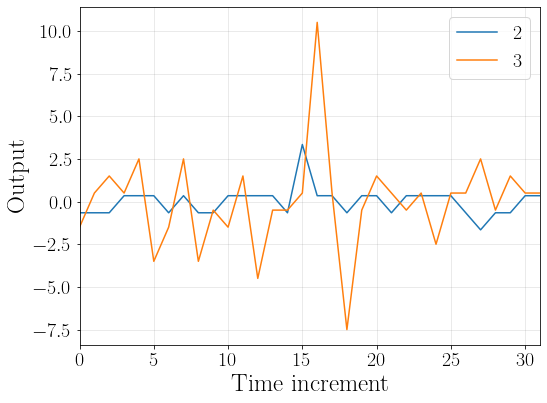

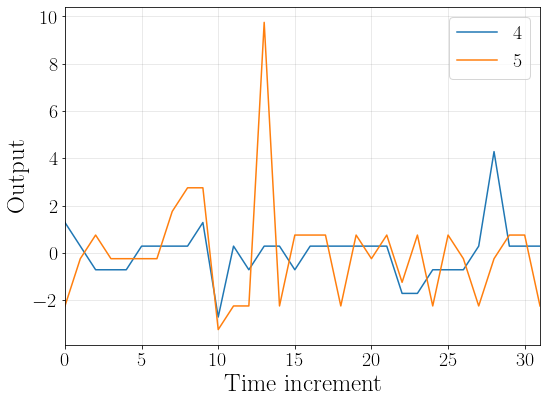

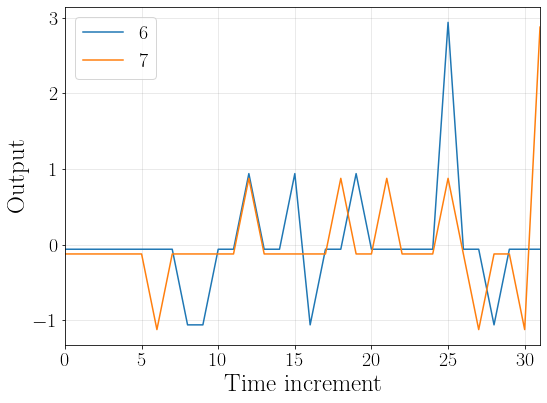

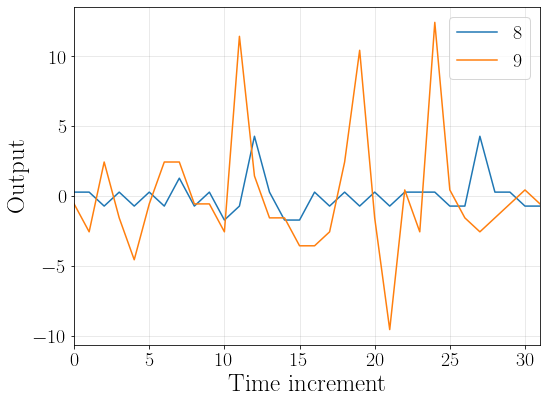

In [61]:
lp.plot_samples_lots(
    low_relative_mean_df.query(
        "std_without_pos_peaks_d_max_m_min > 0.11 and std_without_pos_peaks_d_max_m_min < 0.12"
    ).sample(10),
    minus_mean=True
)

#### Now we perform the cut

# of events: 525


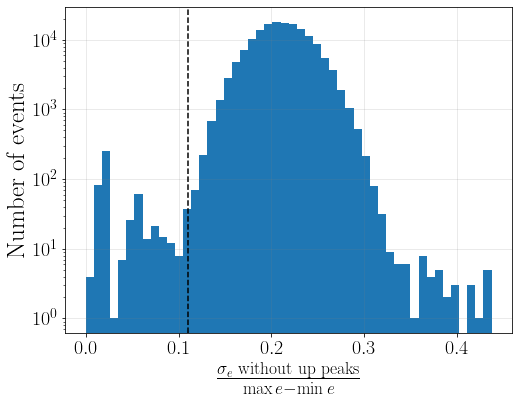

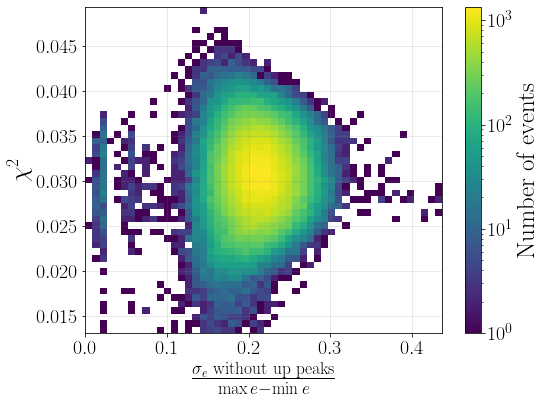

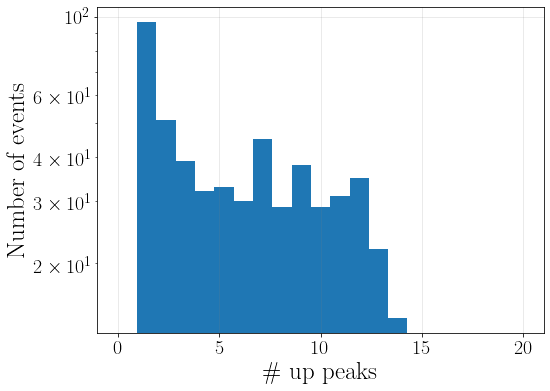

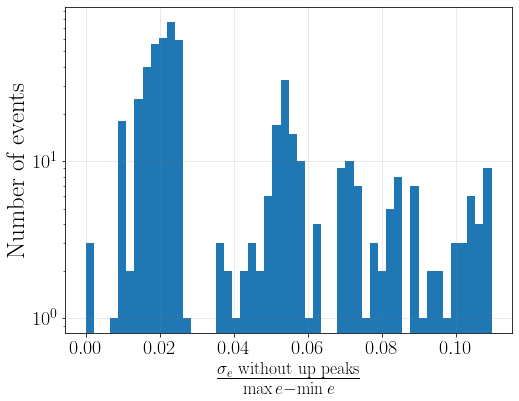

In [62]:
fig, ax = lp.plot_hist(
    low_relative_mean_df["std_without_pos_peaks_d_max_m_min"],
    column_labels["std_without_pos_peaks_d_max_m_min"],
    logscale=True
)

lp.plot_hist2d(
    low_relative_mean_df["std_without_pos_peaks_d_max_m_min"],
    low_relative_mean_df["best_chi2"],    
    column_labels["std_without_pos_peaks_d_max_m_min"],
    column_labels["best_chi2"],
    logscale=True
)

ax.axvline(
    x=std_without_pos_peaks_d_max_m_min_high, 
    color='k', linestyle='--'
)

up_peaks_df = low_relative_mean_df.query(
    f"std_without_pos_peaks_d_max_m_min < {std_without_pos_peaks_d_max_m_min_high}"
    # f"and std_without_pos_peaks_d_max_m_min > 0.1"


)
print("# of events:", len(up_peaks_df))

fig, ax = lp.plot_hist(
    up_peaks_df["nb_pos_peaks"], column_labels["nb_pos_peaks"],
    logscale=True,
    min_max=(0, 20), bins=21
)
fig, ax = lp.plot_hist(
    up_peaks_df["std_without_pos_peaks_d_max_m_min"], column_labels["std_without_pos_peaks_d_max_m_min"],
    logscale=True,
)

# print("# of events:", len(up_peaks_df))

(<Figure size 1728x2160 with 14 Axes>,
 array([[<AxesSubplot:title={'center':'1 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'2 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'3 peaks'}, xlabel='Time increment', ylabel='Output'>],
        [<AxesSubplot:title={'center':'4 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'5 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'6 peaks'}, xlabel='Time increment', ylabel='Output'>],
        [<AxesSubplot:title={'center':'7 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'8 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'9 peaks'}, xlabel='Time increment', ylabel='Output'>],
        [<AxesSubplot:title={'center':'10 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title

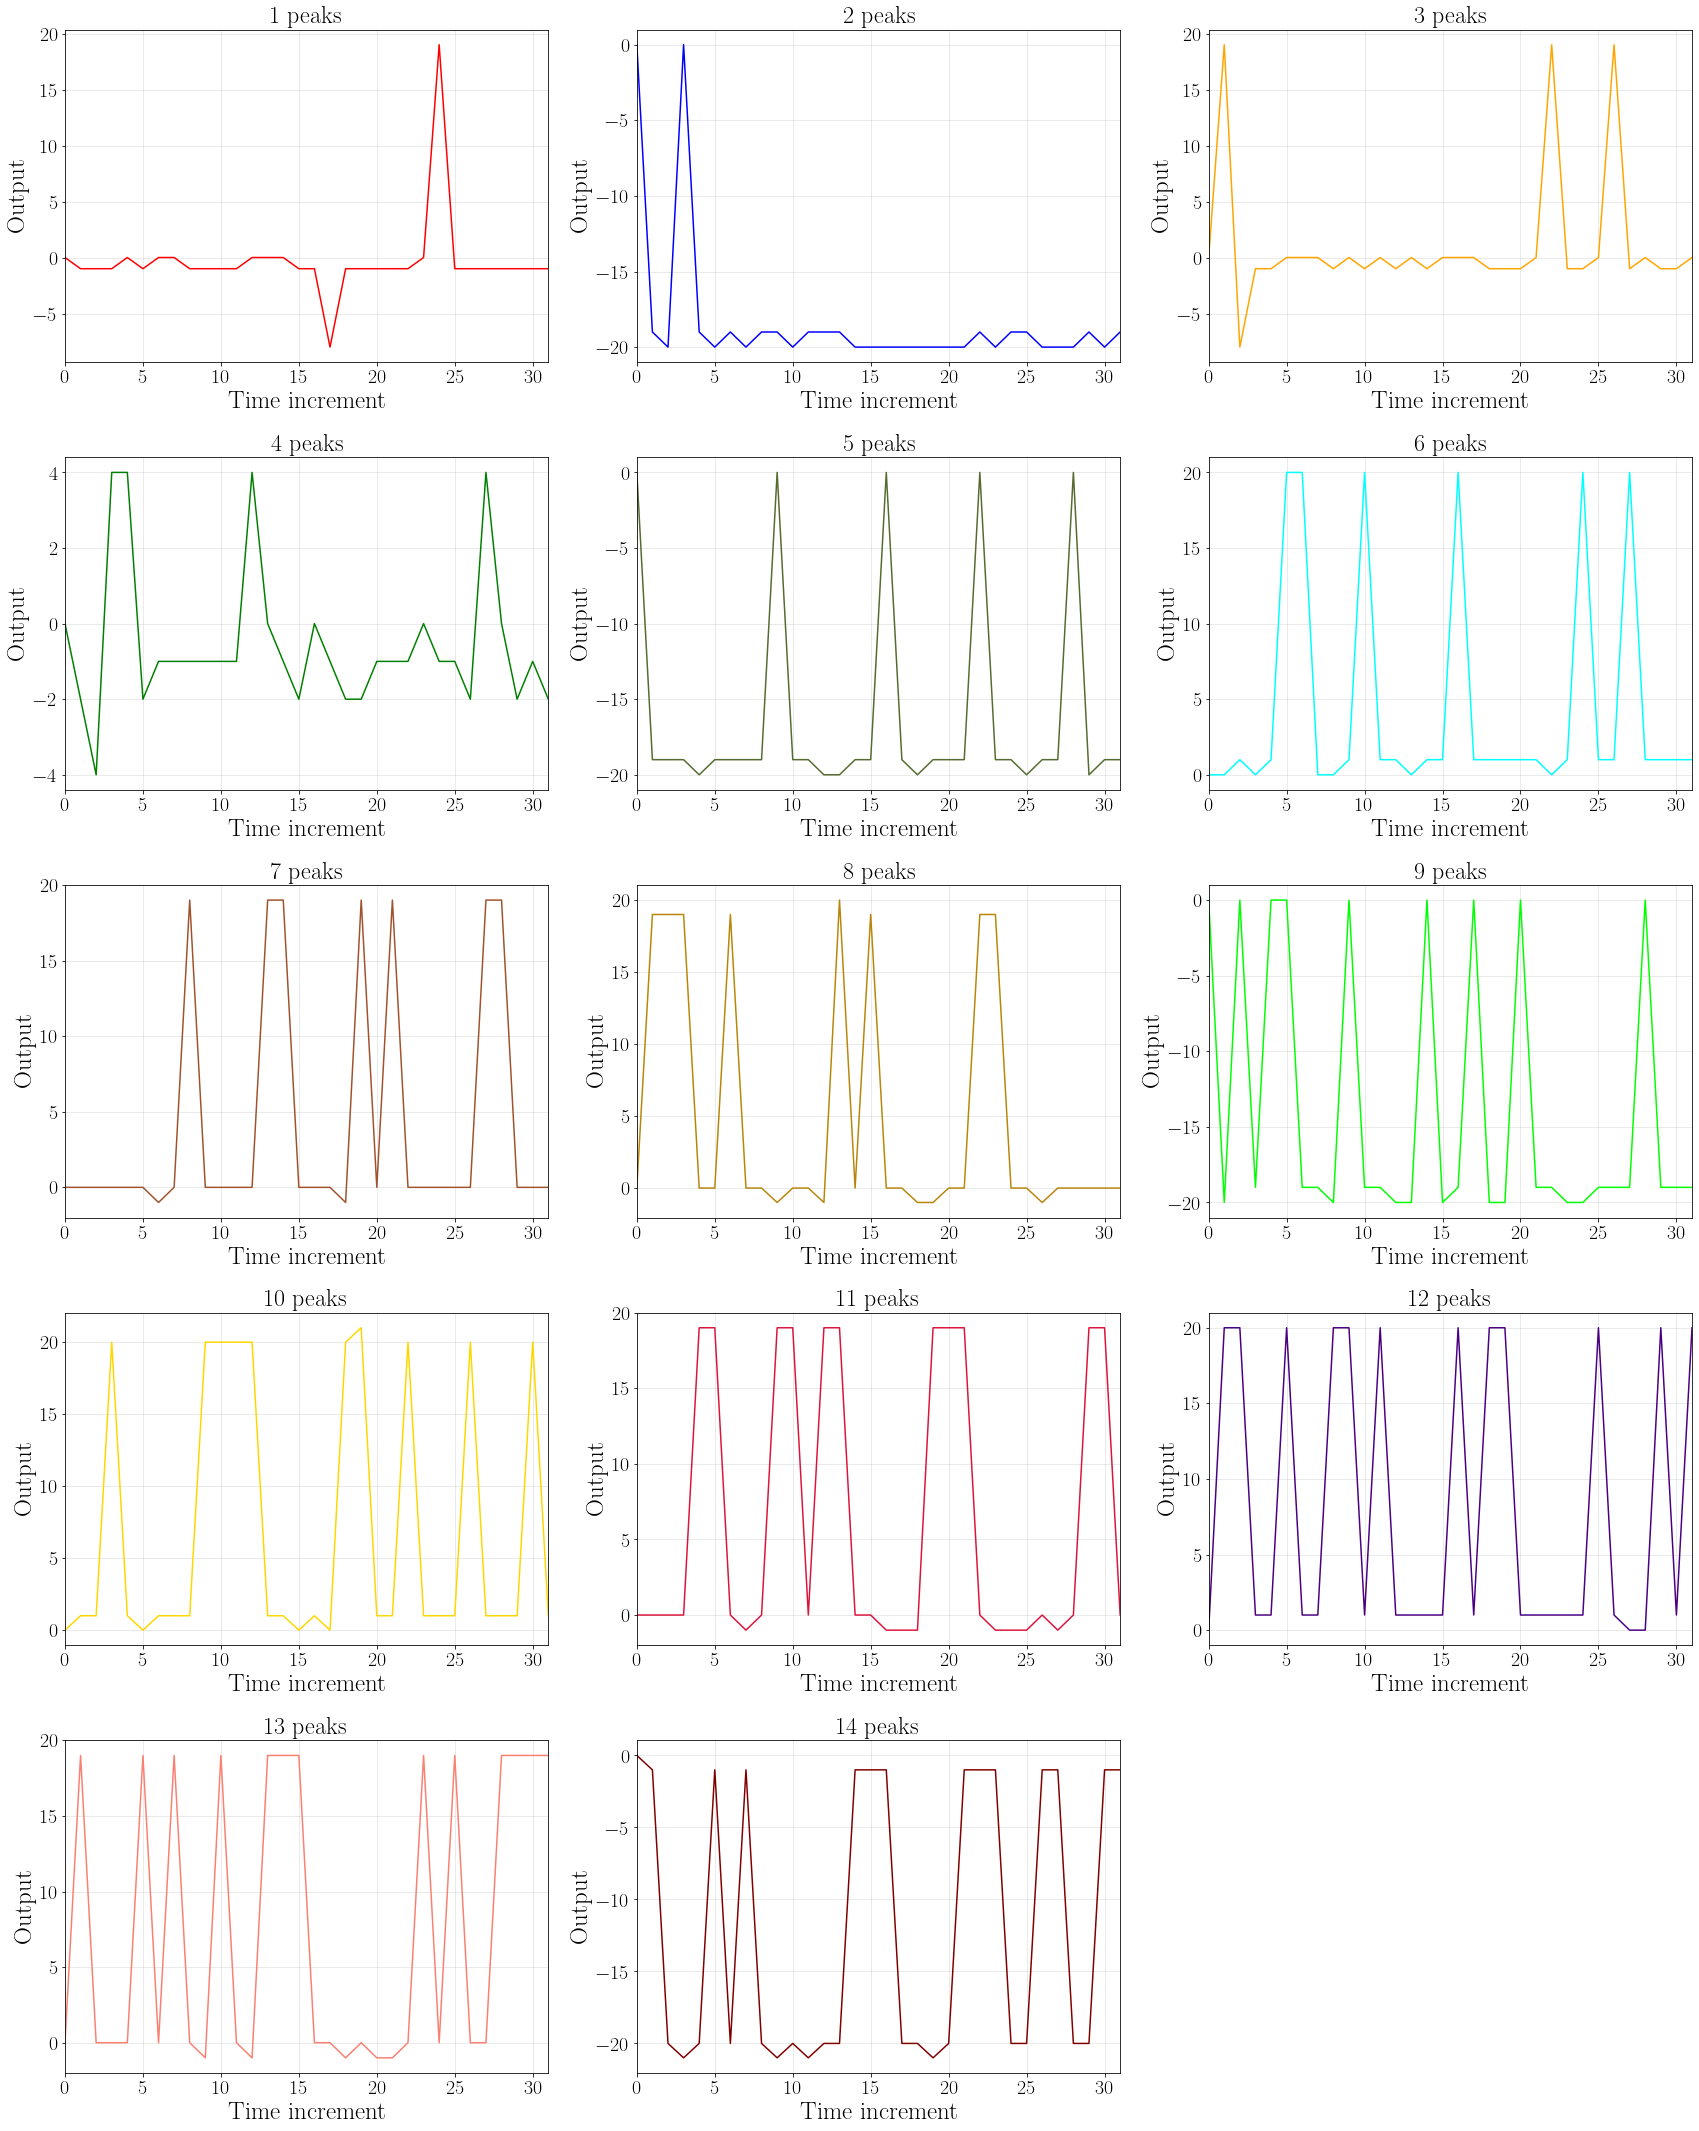

In [51]:
clustering.plot_samples_clusters(
    up_peaks_df,
    "nb_pos_peaks",
    dict_color_clu_labels=dict_color_clu_labels,
    title="{cluster_label} peaks"
)

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\# \\text{ up peaks}$', ylabel='$\\max{e} - \\min{e}$'>)

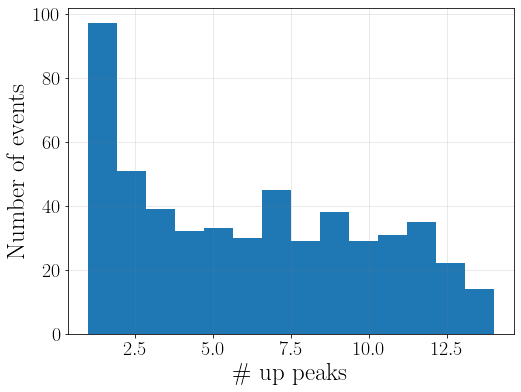

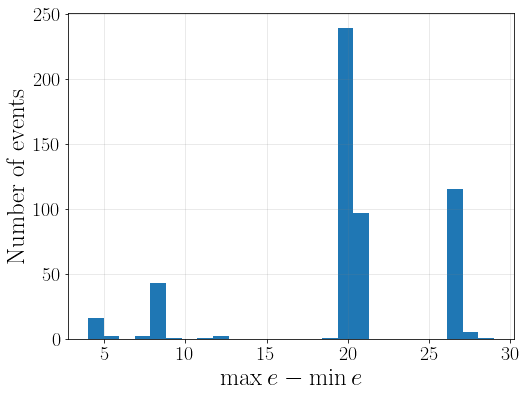

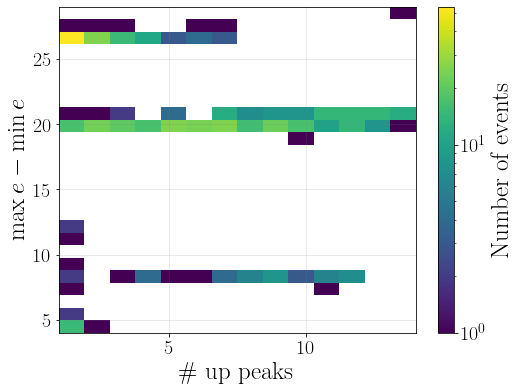

In [63]:
lp.plot_hist(
    up_peaks_df["nb_pos_peaks"], column_labels["nb_pos_peaks"],
    bins="discretised"
)

lp.plot_hist(
    up_peaks_df["max_m_min"], column_labels["max_m_min"],
    bins="discretised"
)

lp.plot_hist2d(
    up_peaks_df["nb_pos_peaks"], up_peaks_df["max_m_min"],
    column_labels["nb_pos_peaks"], column_labels["max_m_min"],
    # min_max=[(1, 13), (1, max(up_peaks_df["max_m_min"]))], 
    bins=["discretised", "discretised"],
    logscale=True
)


### Selection of down peaks


#### Cut on `displaced_mean`

# of events: 463047


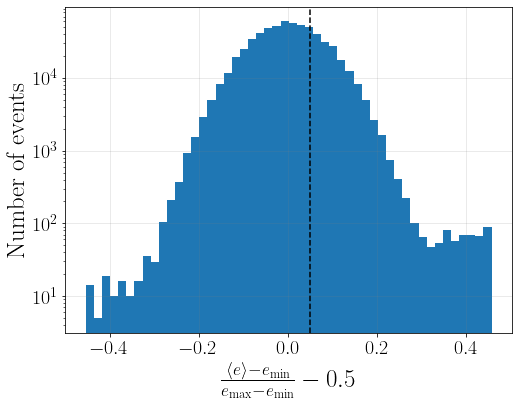

In [105]:
fig, ax = lp.plot_hist(
    high_chi2_df["relative_mean"], column_labels["relative_mean"],
    logscale=True
)

relative_mean_low = 0.05

ax.axvline(
    x=relative_mean_low, color='k', linestyle='--'
)

high_relative_mean_df = high_chi2_df.query(f"relative_mean > {relative_mean_high}")
print("# of events:", len(high_relative_mean_df))

### Cut on `std_without_pos_peaks_d_max_m_min`

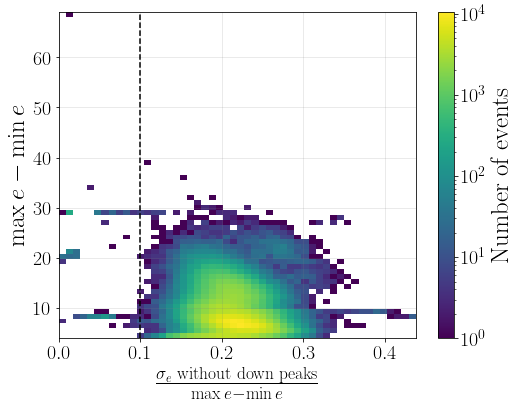

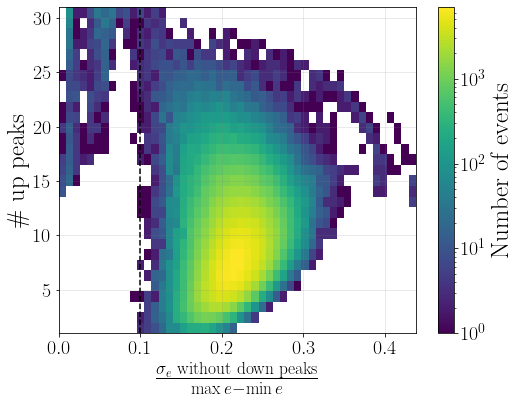

In [107]:
std_without_neg_peaks_d_max_m_min_high = 0.1

fig, ax = lp.plot_hist2d(
    low_relative_mean_df["std_without_neg_peaks_d_max_m_min"],
    low_relative_mean_df["max_m_min"],    
    column_labels["std_without_neg_peaks_d_max_m_min"],
    column_labels["max_m_min"],
    logscale=True,
    bins=[50, "discretised"]
)
fig2, ax2 = lp.plot_hist2d(
    low_relative_mean_df["std_without_neg_peaks_d_max_m_min"],
    low_relative_mean_df["nb_pos_peaks"],    
    column_labels["std_without_neg_peaks_d_max_m_min"],
    column_labels["nb_pos_peaks"],
    logscale=True,
    # min_max=(None, (0, 25)),
    bins=[50, "discretised"]
)
ax.axvline(
    x=std_without_neg_peaks_d_max_m_min_high, 
    color='k', linestyle='--'
)
ax2.axvline(
    x=std_without_neg_peaks_d_max_m_min_high, 
    color='k', linestyle='--'
)


#### Now we perform the cut

# of events: 512


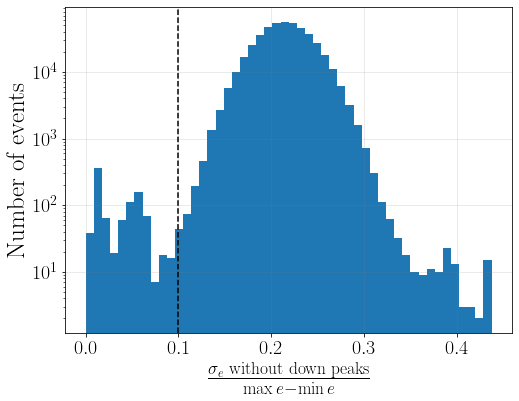

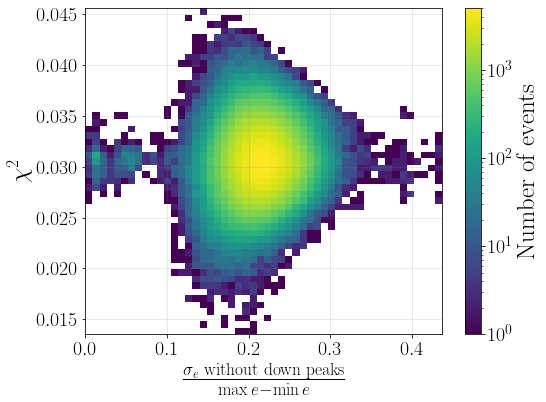

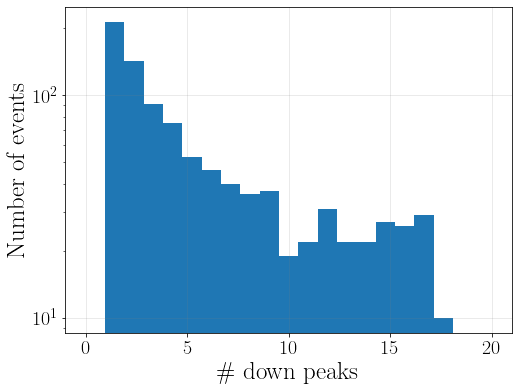

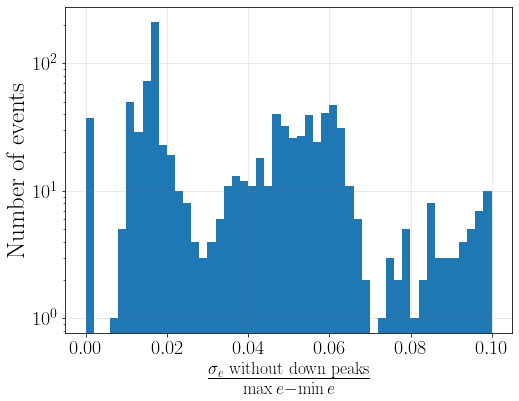

In [110]:
fig, ax = lp.plot_hist(
    low_relative_mean_df["std_without_neg_peaks_d_max_m_min"],
    column_labels["std_without_neg_peaks_d_max_m_min"],
    logscale=True
)

lp.plot_hist2d(
    low_relative_mean_df["std_without_neg_peaks_d_max_m_min"],
    low_relative_mean_df["best_chi2"],    
    column_labels["std_without_neg_peaks_d_max_m_min"],
    column_labels["best_chi2"],
    logscale=True
)

ax.axvline(
    x=std_without_neg_peaks_d_max_m_min_high, 
    color='k', linestyle='--'
)

down_peaks_df = low_relative_mean_df.query(
    f"std_without_neg_peaks_d_max_m_min < {std_without_neg_peaks_d_max_m_min_high}"
    # f"and std_without_pos_peaks_d_max_m_min > 0.1"


)
print("# of events:", len(up_peaks_df))

fig, ax = lp.plot_hist(
    down_peaks_df["nb_neg_peaks"], column_labels["nb_neg_peaks"],
    logscale=True,
    min_max=(0, 20), bins=21
)
fig, ax = lp.plot_hist(
    down_peaks_df["std_without_neg_peaks_d_max_m_min"], column_labels["std_without_neg_peaks_d_max_m_min"],
    logscale=True,
)

# print("# of events:", len(up_peaks_df))

(<Figure size 1728x2592 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'1 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'2 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'3 peaks'}, xlabel='Time increment', ylabel='Output'>],
        [<AxesSubplot:title={'center':'4 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'5 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'6 peaks'}, xlabel='Time increment', ylabel='Output'>],
        [<AxesSubplot:title={'center':'7 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'8 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'9 peaks'}, xlabel='Time increment', ylabel='Output'>],
        [<AxesSubplot:title={'center':'10 peaks'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title

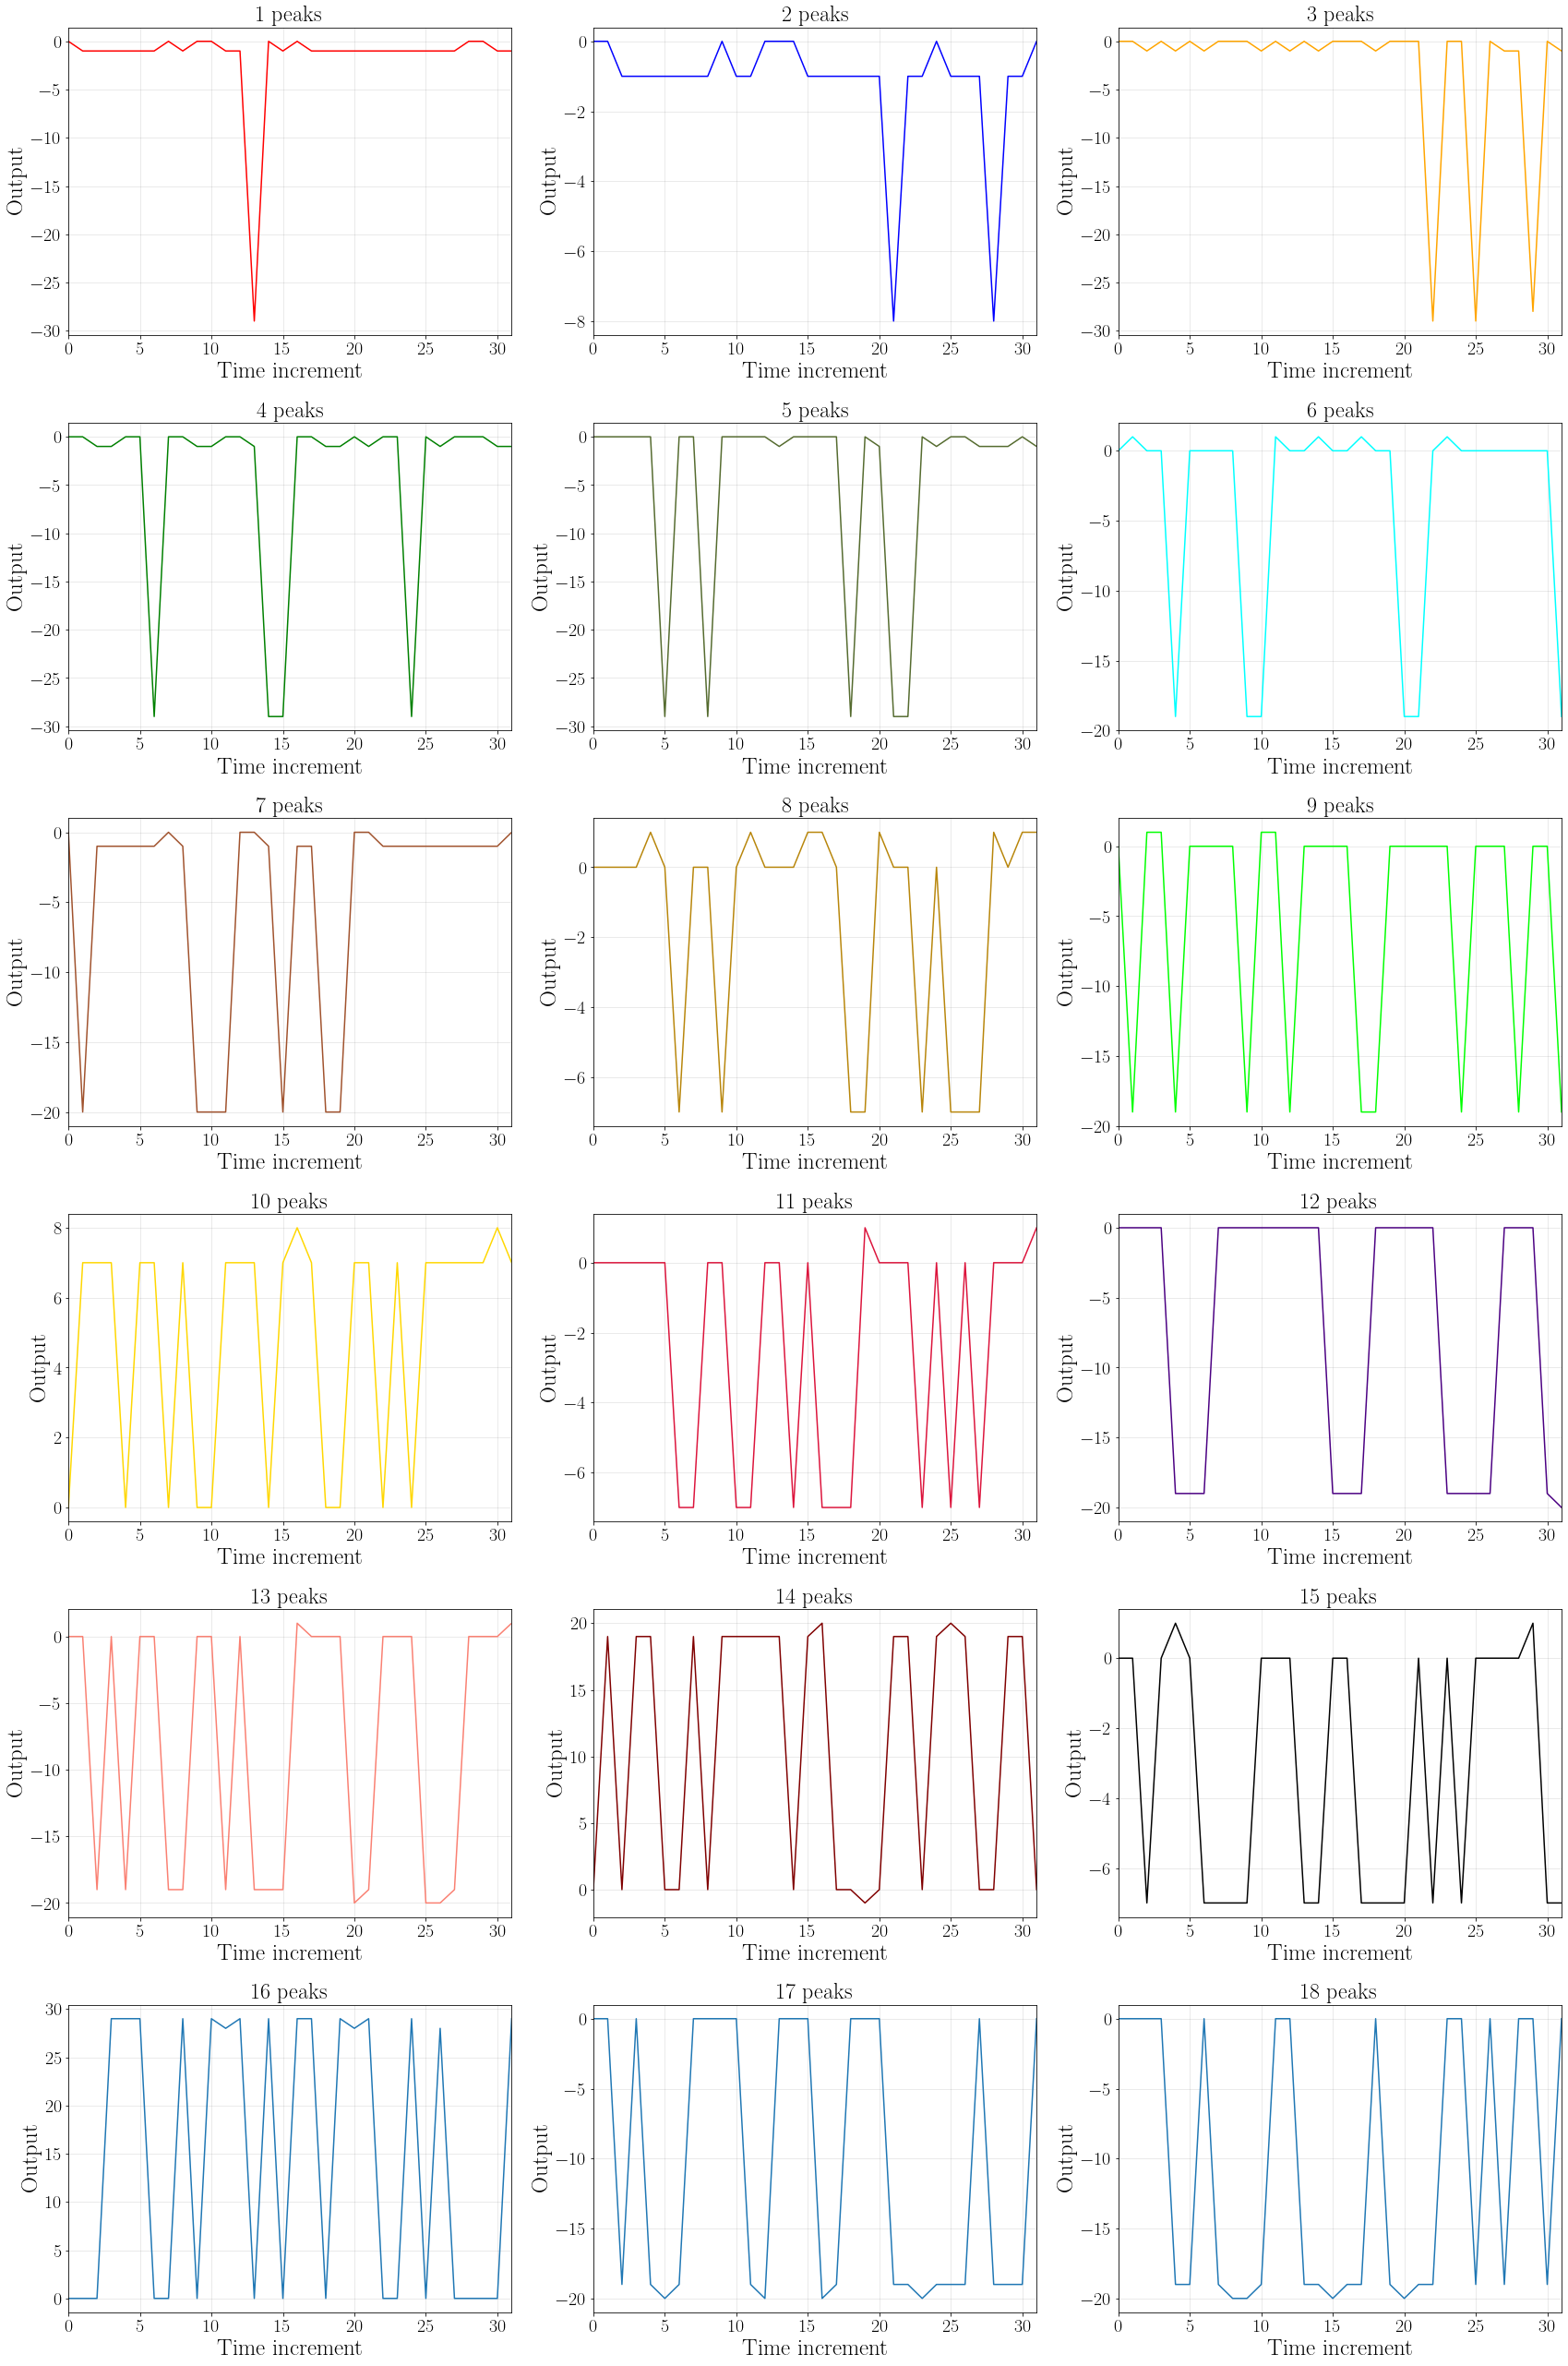

In [113]:
clustering.plot_samples_clusters(
    down_peaks_df,
    "nb_neg_peaks",
    dict_color_clu_labels=dict_color_clu_labels,
    title="{cluster_label} peaks"
)

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\# \\text{ down peaks}$', ylabel='$\\max{e} - \\min{e}$'>)

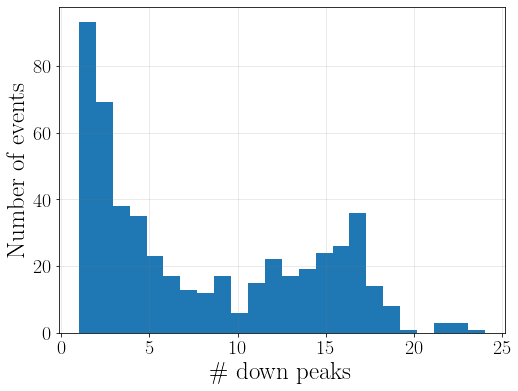

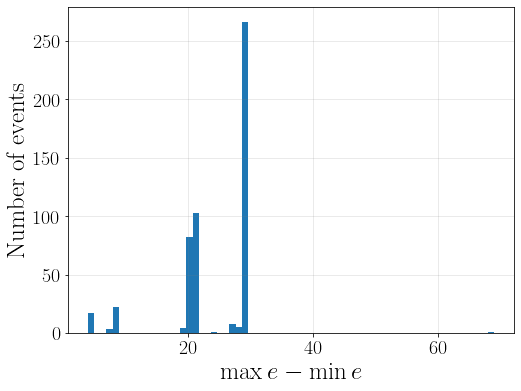

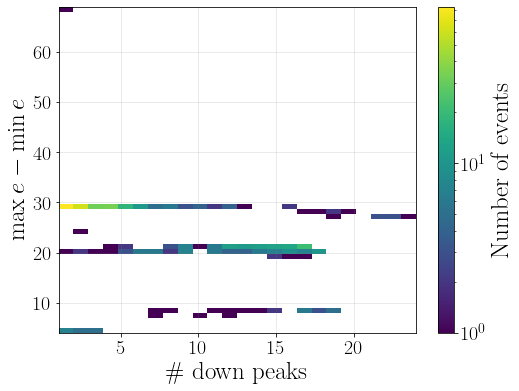

In [115]:
lp.plot_hist(
    up_peaks_df["nb_neg_peaks"], column_labels["nb_neg_peaks"],
    bins="discretised"
)

lp.plot_hist(
    up_peaks_df["max_m_min"], column_labels["max_m_min"],
    bins="discretised"
)

lp.plot_hist2d(
    up_peaks_df["nb_neg_peaks"], up_peaks_df["max_m_min"],
    column_labels["nb_neg_peaks"], column_labels["max_m_min"],
    # min_max=[(1, 13), (1, max(up_peaks_df["max_m_min"]))], 
    bins=["discretised", "discretised"],
    logscale=True
)


## Analysis

### Position in the detector

### In $(\eta, \phi)$

#### Up peaks

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Channel ID', ylabel='Number of events'>)

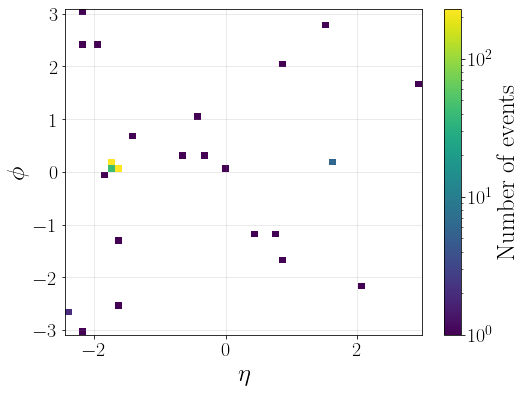

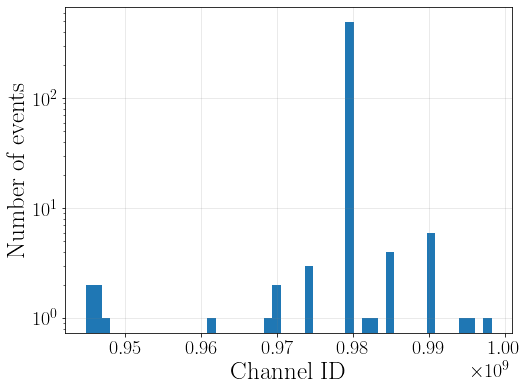

In [74]:
lp.plot_hist2d(
    up_peaks_df["eta"], up_peaks_df["phi"],
    column_labels["eta"], column_labels["phi"],
    logscale=True
)
lp.plot_hist(
    up_peaks_df["channelId"],
    "Channel ID",
    logscale=True
)


In [117]:
up_peaks_df[["channelId", "s0"]].groupby("channelId").count().sort_values("s0", ascending=False)

s0
channelId      
979370496   250
979369984   192
979372032    40
979372544    11
943208448     1
964690944     1
1001411584    1
968894976     1
968889856     1
967837184     1
964696576     1
964179968     1
944773632     1
962605568     1
956832256     1
956315648     1
954739712     1
951587328     1
951069184     1
948439040     1
946867712     1
945299968     1
1001472512    1

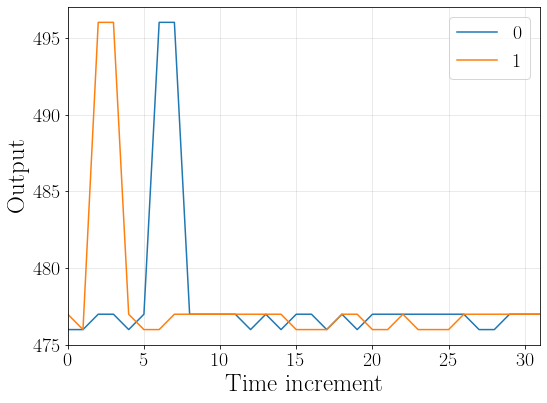

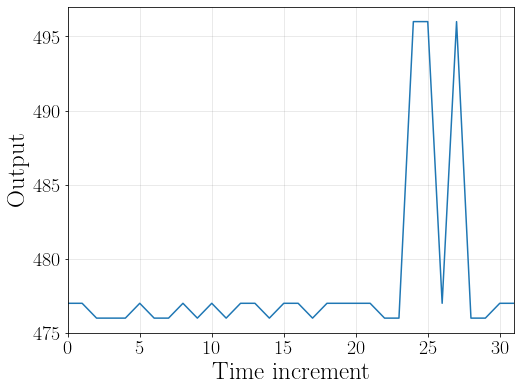

In [118]:
lp.plot_samples_lots(dataframe.query("channelId == 979369984 and best_chi2 < 0.015"))

#### Down peaks

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Channel ID', ylabel='Number of events'>)

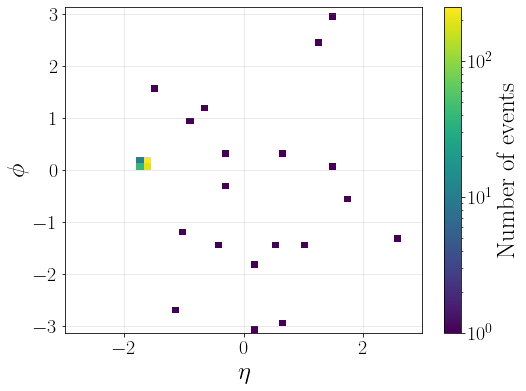

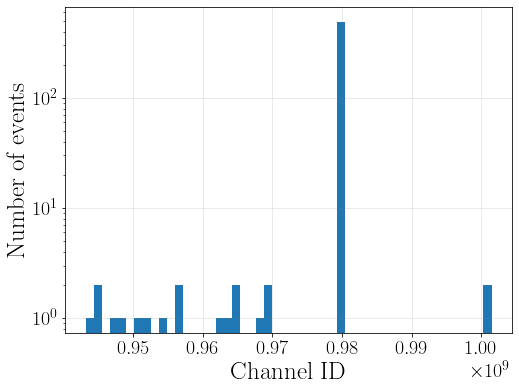

In [124]:
lp.plot_hist2d(
    up_peaks_df["eta"], up_peaks_df["phi"],
    column_labels["eta"], column_labels["phi"],
    logscale=True,
    min_max=((-3., 3.), ((-np.pi, np.pi)))

)
lp.plot_hist(
    up_peaks_df["channelId"],
    "Channel ID",
    logscale=True,
)

In [119]:
down_peaks_df[["channelId", "s0"]].groupby("channelId").count().sort_values("s0", ascending=False)

s0
channelId      
979370496   351
979372032   232
979369984   184
979372544   139
984702976    25
974688256     2
974689792     2
964690944     1
972039680     1
981521920     1
984634368     1
984685056     1
998300160     1
1001472512    1

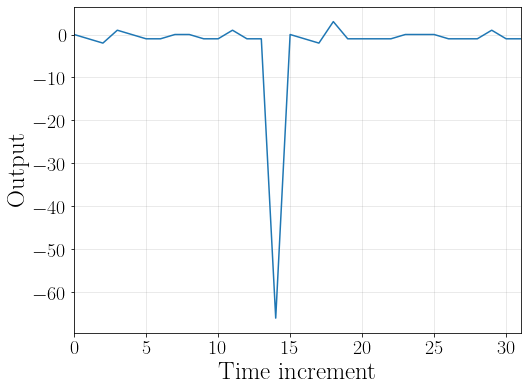

In [121]:
lp.plot_samples_lots(
    down_peaks_df.query("channelId==1001472512"), minus_pedestal=True
)